In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx

In [2]:
n = 10000

m = 100

underlying_graph = nx.barabasi_albert_graph(n=n, m=m)  # 2% density

In [66]:
# Select a target node. In this case, 0 is the highest degree node.
target = 0 # np.random.choice(underlying_graph, size=1)[0]
target

0

In [67]:
underlying_graph.degree(target)

1558

In [68]:
def create_subgraph(graph, num_nodes, with_target=False):
    non_targets = set(graph.nodes) - set([target])
    nodes = list(np.random.choice(list(non_targets), size=num_nodes, replace=False))
    if with_target:
        nodes += [target]
    return graph.subgraph(nodes)

In [69]:
# Divide the graph in 2 (train and test).
aux_graph = create_subgraph(underlying_graph, len(underlying_graph)//2, with_target=True)

test_graph = underlying_graph.subgraph(
    (set(underlying_graph.nodes) - set(aux_graph.nodes)) | set([target])
)

In [70]:
target in aux_graph

True

In [71]:
target in test_graph

True

In [72]:
def create_labelled_samples(graph, num_nodes, target_degree = 20, num_samples=1000):
    labels = np.random.randint(2, size=(num_samples,))
    graphs = []
    for l in labels:
        g = create_subgraph(graph, num_nodes - l, with_target=l)
        graphs.append(g)
    return graphs, labels

In [73]:
private_graph_size = 100
target_node_degree = 10

In [89]:
X_train, y_train = create_labelled_samples(
    aux_graph,
    private_graph_size,
    target_node_degree,
    num_samples = 2000
)

In [90]:
X_test, y_test = create_labelled_samples(
    test_graph,
    private_graph_size,
    target_node_degree,
    num_samples = 2000
)

Use a kernel as embedding (bad lol).

In [91]:
import grakel
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [92]:
from grakel import WeisfeilerLehman, VertexHistogram
kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)

In [93]:
kernel_basis = [create_subgraph(aux_graph, private_graph_size) for _ in range(100)]

In [94]:
kernel.fit(_grak(kernel_basis));

Extract features.

In [95]:
ft_train = kernel.transform(_grak(X_train))

In [96]:
ft_test = kernel.transform(_grak(X_test))

Train a model.

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [98]:
model = RandomForestClassifier()

In [99]:
model.fit(ft_train, y_train)

RandomForestClassifier()

In [100]:
train_scores = model.predict_proba(ft_train)[:,1]

In [101]:
test_scores = model.predict_proba(ft_test)[:,1]

Plot the ROC curves.

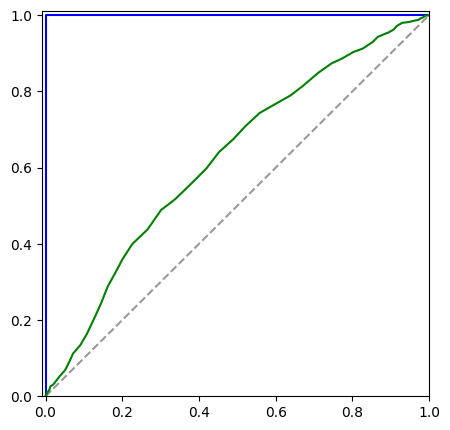

In [102]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], 'k--', alpha=.4)

# Training accuracy!
tpr, fpr, _ = roc_curve(y_train, train_scores)
plt.plot(tpr, fpr, 'b')

# Test accuracy on a disjoint set.
tpr, fpr, _ = roc_curve(y_test, test_scores)
plt.plot(tpr, fpr, 'g')

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);

Can we also do this for the untargeted attack?

In [125]:
import tqdm

In [103]:
def create_generic_samples(graph, num_nodes, num_samples=1000):
    graphs = []
    positives = []
    negatives = []
    for _ in range(num_samples):
        all_nodes = np.random.choice(list(graph.nodes), size=2*num_nodes, replace=False)
        graphs.append(graph.subgraph(all_nodes[:num_nodes]))
        positives.append(all_nodes[:num_nodes])
        negatives.append(all_nodes[num_nodes:])
    return graphs, positives, negatives

In [149]:
def get_khop_neighborhood(graph, node, k=2):
    # ego_graph is what we want, but is incredibly slow.
#     return nx.ego_graph(graph, node, radius=1)
#     nodes = [node] + list(graph.neighbors(node))  # if k==1
    nodes = set([node])
    for i in range(k):
        new_nodes = set()
        for u in nodes:
            new_nodes = new_nodes.union(graph.neighbors(u))
        nodes = nodes.union(new_nodes)
    return graph.subgraph(nodes)

In [150]:
def create_features_generic_samples_naive(graph, num_nodes, num_samples=1000, ft=get_khop_neighborhood):
    X, y = [], []
    for synthetic, positive, negative in zip(*create_generic_samples(graph, num_nodes, num_samples)):
        print('=', end='')
        kernel.fit(_grak([synthetic]))
        subgraphs = [ft(graph, n) for n in list(positive) + list(negative)]
        X.append(kernel.transform(_grak(subgraphs)))
        y += [True] * len(positive) + [False] * len(negative)
    return np.concatenate(X, axis=0), y

In [151]:
def create_features_generic_samples(graph, num_nodes, num_samples=1000, ft=get_khop_neighborhood):
    X, y = [], []
    for synthetic, positive, negative in zip(*create_generic_samples(graph, num_nodes, num_samples)):
        print('=', end='')
        graph_ft = kernel.transform(_grak([synthetic]))
        subgraphs = [ft(graph, n) for n in list(positive) + list(negative)]
        records_ft = kernel.transform(_grak(subgraphs))
        X.append(
            np.concatenate(
                (
                    np.tile(graph_ft, (len(positive)+len(negative), 1)),
                    records_ft
                ), axis=1))
        y += [True] * len(positive) + [False] * len(negative)
    return np.concatenate(X, axis=0), y

In [152]:
X_train, y_train = create_features_generic_samples(aux_graph, 100, 10)

====

  9%|████▊                                                | 9/100 [27:37<4:39:15, 184.12s/it]


In [153]:
X_train.shape

(2000, 200)

In [154]:
X_holdout, y_holdout = create_features_generic_samples(aux_graph, 100, 10)

In [155]:
X_test, y_test = create_features_generic_samples(test_graph, 100, 10)

In [156]:
model = RandomForestClassifier()

In [157]:
model.fit(X_train, y_train)

RandomForestClassifier()

In [158]:
train_scores = model.predict_proba(X_train)[:,1]

In [159]:
holdout_scores = model.predict_proba(X_holdout)[:,1]

In [160]:
test_scores = model.predict_proba(X_test)[:,1]

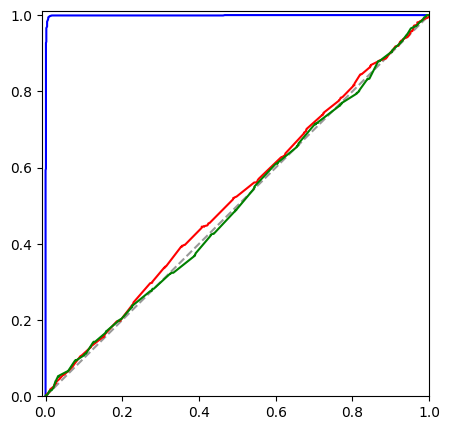

In [161]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], 'k--', alpha=.4)

# Training accuracy!
tpr, fpr, _ = roc_curve(y_train, train_scores)
plt.plot(tpr, fpr, 'b')

# Holdout accuracy!
tpr, fpr, _ = roc_curve(y_holdout, holdout_scores)
plt.plot(tpr, fpr, 'r')

# Test accuracy on a disjoint set.
tpr, fpr, _ = roc_curve(y_test, test_scores)
plt.plot(tpr, fpr, 'g')

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);